<h1>TP3:</h1>  
<h2>Exercice 1: l’algorithme de Deutsch-Jozsa</h2>

Dans cette exercice, nous devons résoudre le problème suivant: 
Nous avons une fonction mathématique 
$f : ${$0,1$}$^𝑛→${$0,1$} Cette fonction est une boite noire mais nous savons qu'elle est soit constante (la sortie est 0 ou 1 pour toutes les entrées) soit équilibrée (la sortie 
est 0 dans la moitié des cas, 1 dans les autres). 


On sait que pour un algorithme classique et déterministe est utilisé alors il faut $2^{n-1}+1$ évaluation de la fonction F pour déterminer si elle est constante ou équilibrée.
Il est est question dans cette exercice d'implémenter l'algorithme quantique de Deutsch-Jozsa dont nous avons suivi l'éxplication ici: https://qiskit.org/textbook/ch-algorithms/deutsch-jozsa.html#1.3-Quantum-Solution--Questions

Dans un premier temps nous allons travailler sur une version de cet algorithme pour l'exemple d'une fonction à trois bits représenté par des fonction oracles constantes et équilibrées (que l'on nommera simplement oracles). Tout d'abord, faisons nos importations:

In [22]:
# Initialisation
import numpy as np

# Import Qiskit
from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, assemble, transpile

# Import des outils graphiques
from qiskit.visualization import plot_histogram

<u>**Mise en place des oracles:**</u>

Dans un premier temps, pour nous familiariser avec les oracles contants et équilibrés nous allons en implémenter:  
Tout d'abord, nous fixons la taille du registre d'entrée de nos oracles :

In [23]:
n = 3

Commençons par créer un oracle constant, dans ce cas l'entrée n'a pas d'effet sur la sortie, donc nous fixons aléatoirement le qubit de sortie à 0 ou 1 :

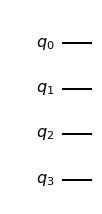

In [24]:
const_oracle = QuantumCircuit(n+1)

output = np.random.randint(2)
if output == 1:
    const_oracle.x(n)

const_oracle.draw("mpl")

Ensuite, nous créons un oracle équilibré.  Nous pouvons créer un oracle équilibré en effectuant des CNOTs avec chaque qubit d'entrée comme contrôle et le bit de sortie comme cible. Nous pouvons varier les états d'entrée qui donnent 0 ou 1 en enveloppant certains des contrôles dans des X-gates. Choisissons d'abord une chaîne binaire de longueur n qui dicte les contrôles à envelopper :

In [25]:
balanced_oracle = QuantumCircuit(n+1)
b_str = "101"

Maintenant que nous avons cette chaîne, nous pouvons l'utiliser comme clé pour placer nos X-gates. Pour chaque qubit dans notre circuit, nous plaçons une X-gate si le chiffre correspondant dans b_str est 1, ou ne faisons rien si le chiffre est 0.

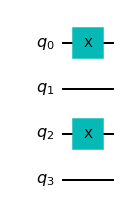

In [26]:
# On place nos portes X
for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_oracle.x(qubit)
balanced_oracle.draw("mpl")

Ensuite, nous faisons nos portes C-NOT, en utilisant chaque qubit d'entrée comme contrôle, et le qubit de sortie comme cible :

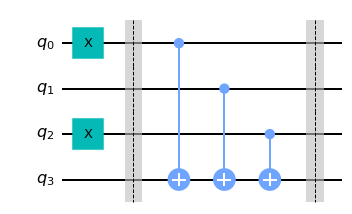

In [27]:
# On divise avec des barrières
balanced_oracle.barrier()

# On met en place l'oracle équilibré
for qubit in range(n):
    balanced_oracle.cx(qubit, n)

balanced_oracle.barrier()
balanced_oracle.draw("mpl")

Enfin, nous répétons le code à partir de deux cellules pour finir d'envelopper les contrôles dans des portes X :

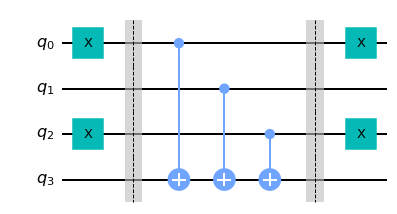

In [28]:
# On place nos portes X
for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_oracle.x(qubit)

# présentation de l'oracle équilibré obtenu:
balanced_oracle.draw("mpl")

<u>**Mise en place de l'algorithme complet:**</u>

Dans un second temps passons à la mise en place de l'algorithme Deutsch-Jozsa . La première étape de l'algorithme consiste à initialiser les qubits d'entrée dans l'état |+⟩ et le qubit de sortie dans l'état  |-⟩:

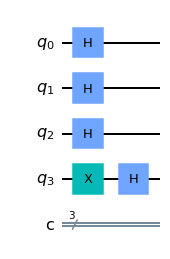

In [29]:
dj_circuit = QuantumCircuit(n+1, n)

# On applique H
for qubit in range(n):
    dj_circuit.h(qubit)

# On met le qubit dans l'état |->
dj_circuit.x(n)
dj_circuit.h(n)
dj_circuit.draw("mpl")

Ensuite, appliquons l'oracle. Ici, nous appliquons l'oracle équilibré: <code>balanced_oracle</code> que nous avons créé plus haut :

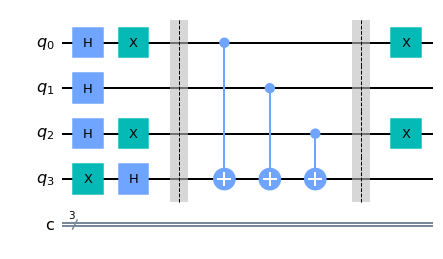

In [31]:
dj_circuit = QuantumCircuit(n+1, n)

# Application de portes H
for qubit in range(n):
    dj_circuit.h(qubit)

# On met le qubit dans l'état |->
dj_circuit.x(n)
dj_circuit.h(n)

# On ajoute notre oracle
dj_circuit += balanced_oracle
dj_circuit.draw("mpl")

Enfin, nous appliquons des portes H sur les  n-qubits d'entrée, et mesurons notre registre d'entrée :

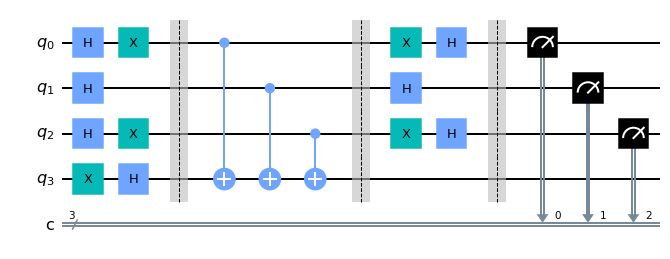

In [32]:
# On repète l'application des portes H
for qubit in range(n):
    dj_circuit.h(qubit)
dj_circuit.barrier()

# On mesure
for i in range(n):
    dj_circuit.measure(i, i)

# On affiche le circuit
dj_circuit.draw("mpl")

Voyons le résultat :

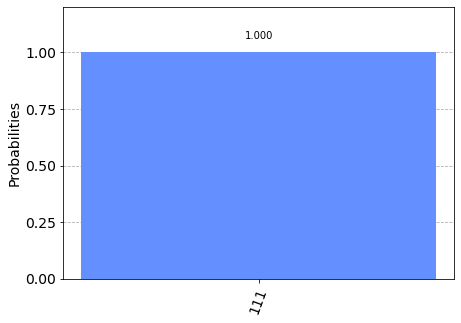

In [33]:
# Utilisation s'un simulateur locale
aer_sim = Aer.get_backend('aer_simulator')
qobj = assemble(dj_circuit, aer_sim)
results = aer_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)

Nous pouvons voir d'après les résultats ci-dessus que nous avons 0 % de chance de mesurer 000. Vis à vis de la mise en place de l'oracle et de l'explication détaillée dans le point 1.4 de la page web: https://qiskit.org/textbook/ch-algorithms/deutsch-jozsa.html#1.3-Quantum-Solution--Questions, cela prédit correctement que la fonction est équilibrée

<u>**Généralisation pour n bits**</u>

Dans un troisième et dernier temps mettons en place une fonction généralisée qui crée des oracles de Deutsch-Jozsa et les transforme en portes quantiques. Elle prend le cas, soit 'équilibré' soit 'constant', et n, la taille du registre d'entrée :

In [34]:
def dj_oracle(case, n):
    # Nous avons besoin de créer un objet QuantumCircuit à retourner
    # Ce circuit a n+1 qubits : 
    # la taille de l'entrée,
    # + un qubit de sortie
    oracle_qc = QuantumCircuit(n+1)
    
    # Tout d'abord, traitons le cas où l'oracle est équilibré
    if case == "balanced":
        # D'abord on génére un nombre aléatoire qui nous indique quels CNOTs à
        # envelopper dans des portes X :
        b = np.random.randint(1,2**n)
        # Ensuite, on formate 'b' comme une chaîne binaire de longueur 'n', complétée par des zéros :
        b_str = format(b, '0'+str(n)+'b')
        # Ensuite, nous plaçons les premières portes X. Chaque chiffre de notre chaîne binaire 
        # correspond à un qubit, si le chiffre est 0, on ne fait rien, si c'est 1
        # on applique une X-gate à ce qubit :
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)
        # On met en place les portes C-NOT pour chaque qubit, en utilisant le qubit de sortie 
        # comme cible :
        for qubit in range(n):
            oracle_qc.cx(qubit, n)
        # Ensuite, on place les dernières portes X
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)

    # Cas dans lequel l'oracle est constant
    if case == "constant":
        # D'abord on décide ce que sera la sortie fixe de l'oracle
        # (soit toujours 0, soit toujours 1)
        output = np.random.randint(2)
        if output == 1:
            oracle_qc.x(n)
    
    oracle_gate = oracle_qc.to_gate()
    oracle_gate.name = "Oracle"
    return oracle_gate

Pour finir créons une fonction qui prend cette porte oracle et exécute l'algorithme de Deutsch-Jozsa sur celle-ci :

In [35]:
def dj_algorithm(oracle, n):
    dj_circuit = QuantumCircuit(n+1, n)
    # Configuration du qubit de sortie :
    dj_circuit.x(n)
    dj_circuit.h(n)
    # Et configuration du registre d'entrée :
    for qubit in range(n):
        dj_circuit.h(qubit)
    # Ajoutons la porte de l'oracle à notre circuit :
    dj_circuit.append(oracle, range(n+1))
    # Enfin, nous appliquons à nouveau les portes H et on mesure :
    for qubit in range(n):
        dj_circuit.h(qubit)
    
    for i in range(n):
        dj_circuit.measure(i, i)
    
    return dj_circuit

Enfin, faisons un test avec l'algorithme final pour un oracle équilibré et n = 4 :

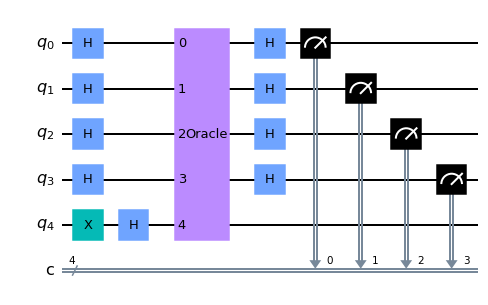

In [36]:
n = 4
oracle_gate1 = dj_oracle('balanced', n)
dj_circuit1 = dj_algorithm(oracle_gate1, n)
dj_circuit1.draw("mpl")

Regardons alors le résultat ici

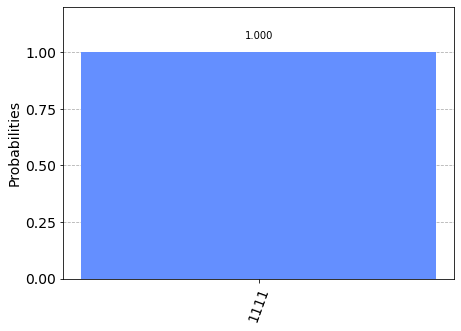

In [37]:
transpiled_dj_circuit1 = transpile(dj_circuit1, aer_sim)
qobj1 = assemble(transpiled_dj_circuit1)
results1 = aer_sim.run(qobj1).result()
answer1 = results1.get_counts()
plot_histogram(answer1)

Enfin, faisons de même pour un oracle constant:

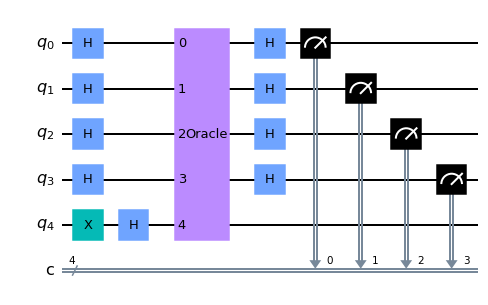

In [38]:
n = 4
oracle_gate2 = dj_oracle('constant', n)
dj_circuit2 = dj_algorithm(oracle_gate2, n)
dj_circuit2.draw("mpl")

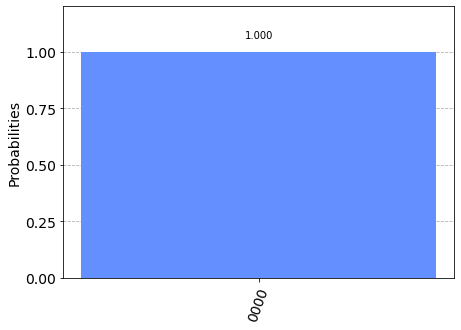

In [39]:
transpiled_dj_circuit2 = transpile(dj_circuit2, aer_sim)
qobj2 = assemble(transpiled_dj_circuit2)
results2 = aer_sim.run(qobj2).result()
answer2 = results2.get_counts()
plot_histogram(answer2)

Les résultats correspondent tout à fait à nos attentes: 
- Nous pouvons voir d'après les résultats ci-dessus que nous avons 0 % de chance de mesurer 0000 pour le premier test. cela prédit correctement que la fonction est équilibrée
- Nous pouvons voir d'après les résultats ci-dessus que nous avons 0 % de chance de mesurer 1111 pour le deuxième test. cela prédit correctement que la fonction est constante

<u>**Expérimentation sur des outils réels**</u>

Maintenant que nous avons bien compris comment fonctionne l’algorithme Deutsch-Jozsa  et que nous l'avons implémenter et tester, nous pouvons exécuter le circuit sur le dispositif réel comme indiqué ci-dessous. 
Nous cherchons d'abord l'appareil le moins occupé qui peut gérer notre circuit.

In [21]:
# Chargement de notre compte IBMQ sauvegardé et obtention du "backend device" le moins occupé avec un nombre de qubits supérieur ou égal à (n+1).
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= (n+1) and
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

least busy backend:  ibmq_bogota


In [22]:
# Executons notre circuit (oracle équilibré) sur le backend le moins occupé. Surveillez l'exécution du travail dans la file d'attente
from qiskit.tools.monitor import job_monitor

transpiled_dj_circuit = transpile(dj_circuit1, backend, optimization_level=3)
job = backend.run(transpiled_dj_circuit)
job_monitor(job, interval=2)

Job Status: job has successfully run


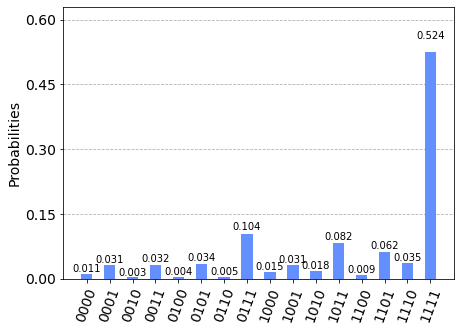

In [23]:
#Resultat:
results = job.result()
answer = results.get_counts()

plot_histogram(answer)

Comme on peut le voir, le résultat le plus probable est 1111. Les autres résultats sont dus à des erreurs dans le calcul quantique. Mise à part cela on peut conclureque  notre algoritme prédit bien que nous avons un oracle équilibré ici (comme attendu).

<h2>Exercice 2: l’algorithme de Simon </h2>
Dans cette exercice, nous devons résoudre le problème suivant:

<u>**Problème de Simon**</u> 
On nous donne une fonction boîte noire inconnue f , dont on garantit qu'elle est soit univoque ( 1 : 1 ), soit bivoque ( 2 : 1 ), où les fonctions univoques et bivoques ont les propriétés suivantes : 
- univoque : fait correspondre exactement une sortie unique pour chaque entrée.  
Un exemple avec une fonction qui prend 4 entrées est : 
f ( 1 ) → 1 , f ( 2 ) → 2 , f ( 3 ) → 3 , f ( 4 ) → 4 
- deux-à-un : fait correspondre exactement deux entrées à chaque sortie unique.  
Un exemple avec une fonction qui prend 4 entrées est :  
f ( 1 ) → 1 , f ( 2 ) → 2 , f ( 3 ) → 1 , f ( 4 ) → 2 
Cette correspondance deux-à-un est selon une chaîne de bits cachée, b , où :
Étant donné x1 , x2 : f ( x1 ) = f ( x2 )  
il est garanti : x1 ⊕ x2 = b 

Étant donné cette boîte noire f , les 2 problèmes sont ici:
 - en combien de temps peut-on déterminer si f est uni- ou bi-univoque ? 
 - Ensuite, si f s'avère être deux à un, en combien de temps pouvons-nous déterminer b ?  
 
Il s'avère que les deux problèmes se résument au même problème de recherche de b , avec:  si b est une chaîne de bits égale 000... alors b représente la f univoque.

***SOLUTION:***

<u> Solution classique: </u>
Classiquement, si nous voulons savoir ce qu'est b avec 100% de certitude pour un f donné, nous devons vérifier jusqu'à $2^{(n-1)} + 1$ entrées, où n est le nombre de bits dans l'entrée. Cela signifie qu'il faut vérifier un peu plus de la moitié de toutes les entrées possibles jusqu'à ce que l'on trouve deux cas de la même sortie. Comme pour le problème de Deutsch-Jozsa, si nous avons de la chance, nous pouvons résoudre le problème avec nos deux premiers essais. Mais si nous avons un f qui est un-à-un, ou si nous sommes vraiment malchanceux avec un f qui est deux-à-un, alors nous sommes coincés et devons réaliser  $2^{(n-1)} + 1$ calculs. Il existe des algorithmes connus qui ont une limite inférieure de $\Omega(2^{n/2})$ mais en général, la complexité croît exponentiellement avec n.

<u>Solution quantique:</u>
Le circuit quantique qui met en œuvre l'algorithme de Simon est illustré ci-dessous.
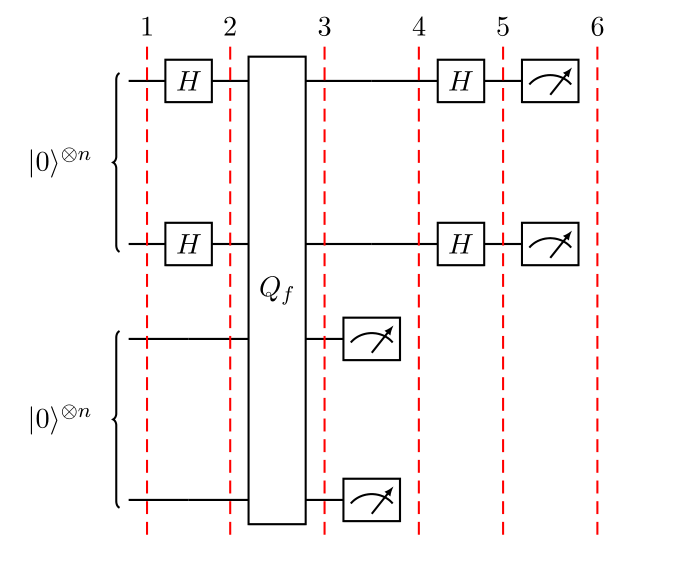

Où la fonction de requête, $\text{Q}_f$ agit sur deux registres quantiques tel que:   
| x ⟩ | a ⟩ → | x ⟩ | a ⊕ f ( x ) ⟩   
Dans le cas particulier où le deuxième registre est dans l'état | 0 ⟩ = | 00 ... 0 ⟩   
on a : | x ⟩ | 0 ⟩ → | x ⟩ | f ( x ) ⟩   
L'algorithme comporte les étapes suivantes: (que nous suivrons pour l'implémentation qui suit) 
- 1. Deux registres d'entrée de n qubits sont initialisés à l'état zéro :
$\lvert \psi_1 \rangle = \lvert 0 \rangle^{\otimes n} \lvert 0 \rangle^{\otimes n}$
- 2. Appliquer Hadamard sur le premier registre pour obtenir la transformation suivant: 
$\lvert \psi_2 \rangle = \frac{1}{\sqrt{2^n}} \sum_{x \in \{0,1\}^{n} } \lvert x \rangle\lvert 0 \rangle^{\otimes n}$
- 3. Appliquer $\text{Q}_f$:  
$\lvert \psi_3 \rangle = \frac{1}{\sqrt{2^n}} \sum_{x \in \{0,1\}^{n} } \lvert x \rangle \lvert f(x) \rangle$
- 3. Mesurez le deuxième registre. Une certaine valeur de f (x) sera observée. En raison de la configuration du problème, la valeur observée f (x) pourrait correspondre à deux entrées possibles : x et y = x ⊕ b . Par conséquent, le premier registre devient : $\lvert \psi_4 \rangle = \frac{1}{\sqrt{2}}  \left( \lvert x \rangle + \lvert y \rangle \right)$ où nous avons omis le deuxième registre puisqu'il a été mesuré.
- 5. On applique une nouvelle fois H sur le premier registre et on obtient:  
$\lvert \psi_5 \rangle = \frac{1}{\sqrt{2^{n+1}}} \sum_{z \in \{0,1\}^{n} } \left[  (-1)^{x \cdot z} + (-1)^{y \cdot z} \right]  \lvert z \rangle$
- 6. Enfin la mesure du premier registre ne donnera une sortie que si : $(-1)^{x \cdot z} = (-1)^{y \cdot z}$ ce qui signifie :  
$x \cdot z = y \cdot z \\
     x \cdot z = \left( x \oplus b \right) \cdot z \\
     x \cdot z = x \cdot z \oplus b \cdot z \\
     b \cdot z = 0 \text{ (mod 2)}$  
     On mesurera une chaîne z dont le produit interne avec b = 0 . Ainsi, en répétant l'algorithme ≈ n fois, on pourra obtenir n valeurs différentes de z et le système d'équation suivant pourra être écrit :  
     $\begin{cases} b \cdot z_1 = 0 \\ b \cdot z_2 = 0 \\ \quad \vdots \\ b \cdot z_n = 0 \end{cases}$  
     Dont  b peut être déterminé, par exemple par élimination gaussienne.
     
Ainsi, dans ce problème particulier, l'algorithme quantique effectue exponentiellement moins d'étapes que l'algorithme classique. Une fois de plus, il peut être difficile d'envisager une application de cet algorithme mais il représente la première preuve qu'il peut y avoir une accélération exponentielle dans la résolution d'un problème spécifique en utilisant un ordinateur quantique plutôt qu'un ordinateur classique.

<u>**Implémentation de  l'algorithme de Simon pour n qubit supporté d'un exemple avec 3 qubits et b = 101**</u>

In [40]:
# import de Qiskit
from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, transpile, assemble

# import des outils de base du tracé
from qiskit.visualization import plot_histogram
from qiskit_textbook.tools import simon_oracle

La fonction simon_oracle (importée ci-dessus) crée un oracle de Simon pour la chaîne de bits b. 
Dans le cas de l'algorithme de Simon, nous ne nous soucions pas de la sortie du second registre, et nous ne mesurerons que le premier registre.

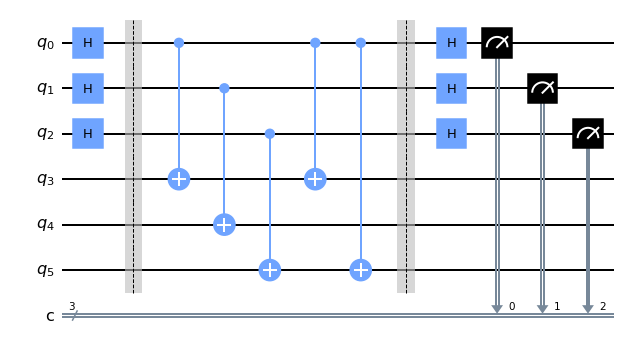

In [41]:
b = '101'

n = len(b)
simon_circuit = QuantumCircuit(n*2, n)

# Appliquer les portes Hadamard avant d'interroger l'oracle
simon_circuit.h(range(n))    
    
# Appliquer une barrière pour la séparation visuelle
simon_circuit.barrier()

# Requête oracle
simon_circuit += simon_oracle(b)

# Appliquer une barrière pour la séparation visuelle
simon_circuit.barrier()

# Appliquer des portes Hadamard au registre d'entrée
simon_circuit.h(range(n))

# Mesure des qubits
simon_circuit.measure(range(n), range(n))
simon_circuit.draw("mpl")

Nous pouvons faire fonctionner le circuit ci-dessus sur le simulateur.

C:\Users\louis\anaconda3\envs\ENV_NAME\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


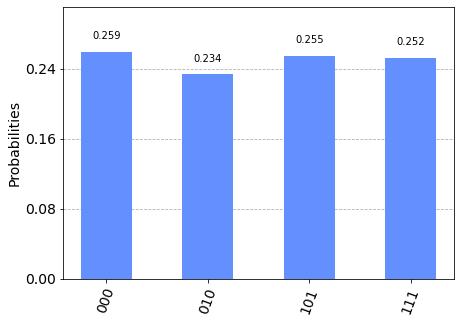

In [10]:
# Utilisation d'un simulateur globale
aer_sim = Aer.get_backend('aer_simulator')
shots = 1024
qobj = assemble(simon_circuit, shots=shots)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)

Puisque nous connaissons déjà b, nous pouvons vérifier que ces résultats satisfont b ⋅ z = 0 ( mod 2 ) :

In [11]:
# Calcul du produit scalaire des résultats
def bdotz(b, z):
    accum = 0
    for i in range(len(b)):
        accum += int(b[i]) * int(z[i])
    return (accum % 2)

for z in counts:
    print( '{}.{} = {} (mod 2)'.format(b, z, bdotz(b,z)) )

101.101 = 0 (mod 2)
101.111 = 0 (mod 2)
101.010 = 0 (mod 2)
101.000 = 0 (mod 2)


En utilisant ces résultats, nous pouvons retrouver la valeur de b = 101 en résolvant cet ensemble d'équations simultanées. Par exemple, disons que nous avons d'abord mesuré 010, cela nous indique : 
$\require{cancel}
\begin{aligned}
b \cdot 001 &= 0 \pmod{2} \\
(b_2 \cdot 0) + (b_1 \cdot 1) + (b_0 \cdot 0) & = 0  \pmod{2} \\
(\cancel{b_2 \cdot 0}) + (b_1 \cdot 1) +(\cancel{b_0 \cdot 0}) & = 0  \pmod{2}\\
b_1 & = 0\\
\end{aligned}$

Si nous mesurons ensuite 111, nous avons : 

$\require{cancel}
\begin{aligned}
b \cdot 111 &= 0 \pmod{2}\\
(b_2 \cdot 1) + (\cancel{0 \cdot 1}) + (b_0 \cdot 1) & = 0 \pmod{2} \\
(b_2 \cdot 1) + (b_0 \cdot 1) & = 0 \pmod{2}\\
\end{aligned}$

Ce qui nous indique:   
$b_2 = b_0 = 0, \quad b = 000$  
ou  
$b_2 = b_0 = 1, \quad b = 101$  

Donc b = 101 est la solution non triviale de nos équations simultanées. Nous pouvons résoudre ces problèmes en général en utilisant l'élimination gaussienne, qui a un temps d'exécution de $O(n^3)$.

<u>**Expérimentation sur des outils réels**</u>

Nous allons exécuter le même code, mais en utilisant plutôt b = 11 ne nécessitant que 4 qubits.

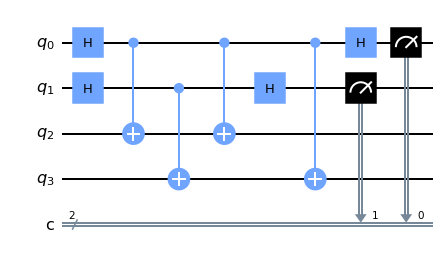

In [42]:
b = '11'
n = len(b)
simon_circuit_2 = QuantumCircuit(n*2, n)

# Appliquer les portes Hadamard avant de lancer l'oracle
simon_circuit_2.h(range(n))

# Requête oracle
simon_circuit_2 += simon_oracle(b)

# Appliquer des portes Hadamard au registre d'entrée
simon_circuit_2.h(range(n))

#Mesure
simon_circuit_2.measure(range(n), range(n))
simon_circuit_2.draw("mpl")

In [13]:
# Chargement de notre compte IBMQ sauvegardé et obtention du "backend device" le moins occupé avec 5 qubits ou moins.
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= n and 
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

# Exécuter et suivre le "job"
from qiskit.tools.monitor import job_monitor
shots = 1024
transpiled_simon_circuit = transpile(simon_circuit_2, backend, optimization_level=3)
qobj = assemble(transpiled_simon_circuit, shots=shots)
job = backend.run(qobj)
job_monitor(job, interval=2)

ibmqfactory.load_account:WARNING:2021-12-23 19:34:41,326: Credentials are already in use. The existing account in the session will be replaced.


least busy backend:  ibmq_lima


C:\Users\louis\AppData\Local\Temp/ipykernel_8392/2433331205.py:13: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(qobj)


Job Status: job has successfully run


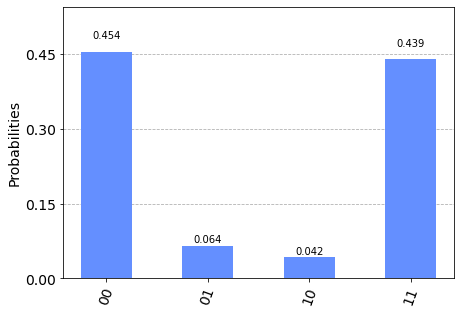

In [14]:
# Obtention des résultats et tracer du graph associé
device_counts = job.result().get_counts()
plot_histogram(device_counts)

In [15]:
# Calcul du produit scalaire des résultats
def bdotz(b, z):
    accum = 0
    for i in range(len(b)):
        accum += int(b[i]) * int(z[i])
    return (accum % 2)

print('b = ' + b)
for z in device_counts:
    print( '{}.{} = {} (mod 2) ({:.1f}%)'.format(b, z, bdotz(b,z), device_counts[z]*100/shots))

b = 11
11.00 = 0 (mod 2) (45.4%)
11.01 = 1 (mod 2) (6.4%)
11.10 = 1 (mod 2) (4.2%)
11.11 = 0 (mod 2) (43.9%)


Comme on peut le constater, les résultats les plus significatifs sont ceux pour lesquels b ⋅ z = 0 (mod 2). Les autres résultats sont erronés, mais ont une probabilité plus faible de se produire. En supposant que nous avons peu de chances de mesurer les résultats erronés, nous pouvons alors utiliser un ordinateur classique pour retrouver la valeur de b en résolvant le système d'équations linéaires. Pour ce cas n = 2, b = 11 .
